In [1]:
from mplsoccer import Pitch, Sbopen
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
parser = Sbopen()
df = parser.match(competition_id = 55,season_id = 43)
match_ids = df[(df['home_team_name']=='Spain') | (df['away_team_name']=='Spain')]['match_id'].to_list()
no_games = len(match_ids)
no_games

6

In [3]:
df = parser.event(match_ids[0])[0]

In [4]:
df = df[["type_name","x", "y", "end_x", "end_y", "minute", "second", "player_name",'team_name']]
df['type_name'] = np.where(((df.type_name=='Miscontrol') | (df.type_name=='Dispossessed')),'Ball Lost',df.type_name)
recov = df[((df['type_name']=='Ball Recovery') & (df['team_name']=='Spain'))| ((df['type_name']=='Ball Lost') & (df['team_name']!='Spain') )]
recov

,type_name,x,y,end_x,end_y,minute,second,player_name,team_name
204,Ball Lost,72.6,45.9,NaN,NaN,4,51,Federico Chiesa,Italy
225,Ball Lost,53.7,24.6,NaN,NaN,5,28,Ciro Immobile,Italy
226,Ball Recovery,62.1,70.1,NaN,NaN,5,29,Eric García Martret,Spain
281,Ball Lost,34.1,77.6,NaN,NaN,6,13,Federico Chiesa,Italy
324,Ball Lost,85.6,32.5,NaN,NaN,6,50,Ciro Immobile,Italy
...,...,...,...,...,...,...,...,...,...
4644,Ball Recovery,55.9,47.7,NaN,NaN,114,16,Rodrigo Hernández Cascante,Spain
4665,Ball Recovery,96.3,53.4,NaN,NaN,114,44,Marcos Llorente Moreno,Spain
4716,Ball Lost,54.8,31.6,NaN,NaN,116,29,Andrea Belotti,Italy
4717,Ball Recovery,65.9,48.3,NaN,NaN,116,30,Thiago Alcântara do Nascimento,Spain


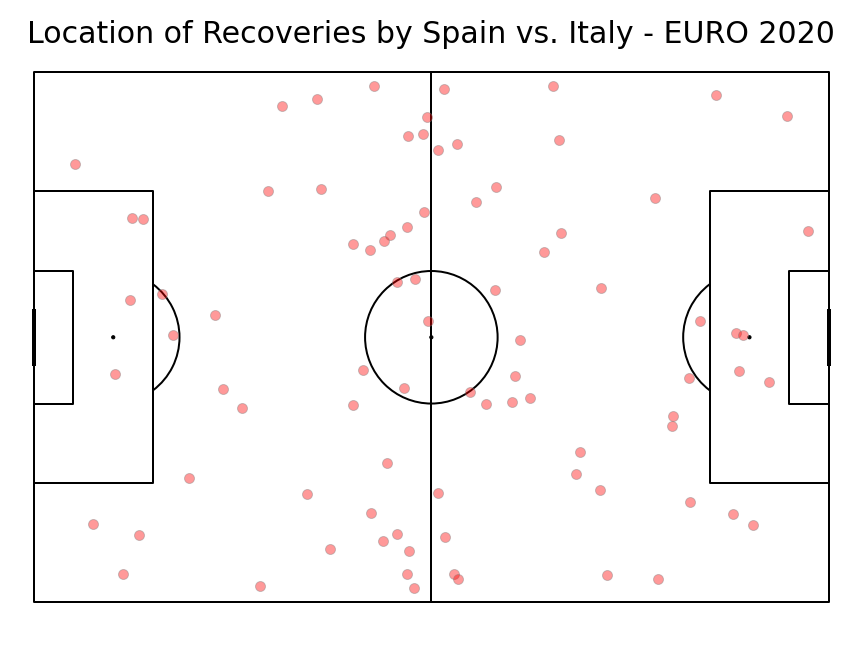

In [5]:
#plot pitch
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
pitch.scatter(recov.x, recov.y, s=100, color='red', edgecolors='grey', linewidth=1, alpha=0.4, ax=ax["pitch"])

fig.suptitle('Location of Recoveries by Spain vs. Italy - EURO 2020' ,fontsize = 30)
plt.show()

In [6]:
team = 'Spain'

In [7]:
recoveries = pd.DataFrame()
full_recov = pd.DataFrame()

for i in match_ids:
    df = parser.event(i)[0]
    rival = list(df[~df.team_name.str.contains(team)].team_name.unique())[0]
    df['type_name'] = np.where(((df.type_name=='Miscontrol') | (df.type_name=='Dispossessed')),'Ball Lost',df.type_name)   
    for period in [1,2]:
        df = df[["x", "y", "minute", "second", "player_name","team_name","period","type_name"]]
        recov = df[(df.period == period) & (((df['team_name'].str.contains(team)) & (df.type_name=='Ball Recovery')) | ((df.type_name=='Ball Lost') & (~df['team_name'].str.contains(team))))]
        recov_rival = df[(df.period == period) & (((df['team_name'].str.contains(team)) & (df.type_name=='Ball Lost')) | ((df.type_name=='Ball Recovery') & (~df['team_name'].str.contains(team))))]
        #recov['Rival'] = rival
        recov_rival = recov_rival[['minute','second']]
        lost_times = recov_rival['minute']*60+recov_rival['second']
        recov_times = recov['minute']*60+recov['second']
        window = 7 # seconds
        play_end = lost_times + window
        
        #play_end = play_end.apply(lambda i: i if i<0 else (period-1)*45)
        cpress = recov_times.apply(lambda x: True in ((x<play_end) & (x>lost_times)).unique())
        
        recoveries_period = recov[cpress]
        recoveries = pd.concat([recoveries,recoveries_period])
        full_recov = pd.concat([full_recov,recov])

recoveries

,x,y,minute,second,player_name,team_name,period,type_name
445,13.5,75.7,9,22,Nicolò Barella,Italy,1,Ball Lost
446,113.6,6.6,9,22,Ferrán Torres García,Spain,1,Ball Recovery
703,9.0,68.2,13,8,Leonardo Bonucci,Italy,1,Ball Lost
1369,57.4,77.8,30,22,Federico Chiesa,Italy,1,Ball Lost
1980,86.5,75.9,46,0,Eric García Martret,Spain,2,Ball Recovery
...,...,...,...,...,...,...,...,...
1028,42.6,72.0,32,24,Lukáš Haraslín,Slovakia,1,Ball Lost
1256,21.9,29.5,38,24,Unai Simón Mendibil,Spain,1,Ball Recovery
1625,91.4,45.9,47,22,Pedro González López,Spain,1,Ball Recovery
2487,64.4,43.8,69,0,Jorge Resurrección Merodio,Spain,2,Ball Recovery


In [8]:
recoveries.type_name.value_counts()

Ball Recovery    46
Ball Lost        24
Name: type_name, dtype: int64

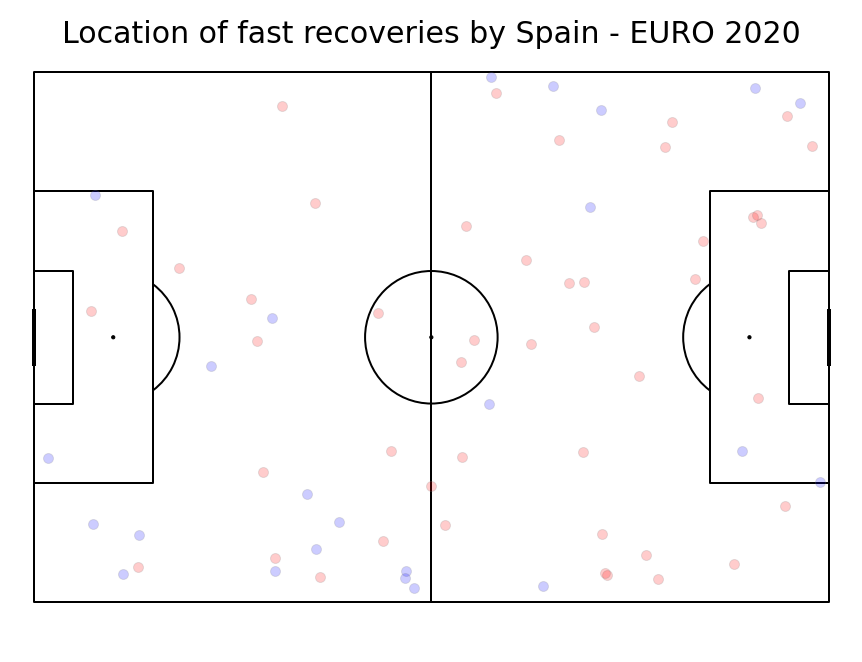

In [9]:
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#scatter the location on the pitch
recov = recoveries[recoveries.team_name=='Spain']
lost = recoveries[recoveries.team_name!='Spain']
pitch.scatter(recov.x, recov.y, s=100, color='red', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
pitch.scatter(lost.x, lost.y, s=100, color='blue', edgecolors='grey', linewidth=1, alpha=0.2, ax=ax["pitch"])
#uncomment it to plot arrows
#pitch.arrows(danger_passes.x, danger_passes.y, danger_passes.end_x, danger_passes.end_y, color = "blue", ax=ax['pitch'])
#add title
fig.suptitle('Location of fast recoveries by ' + team + ' - EURO 2020', fontsize = 30)
plt.show()

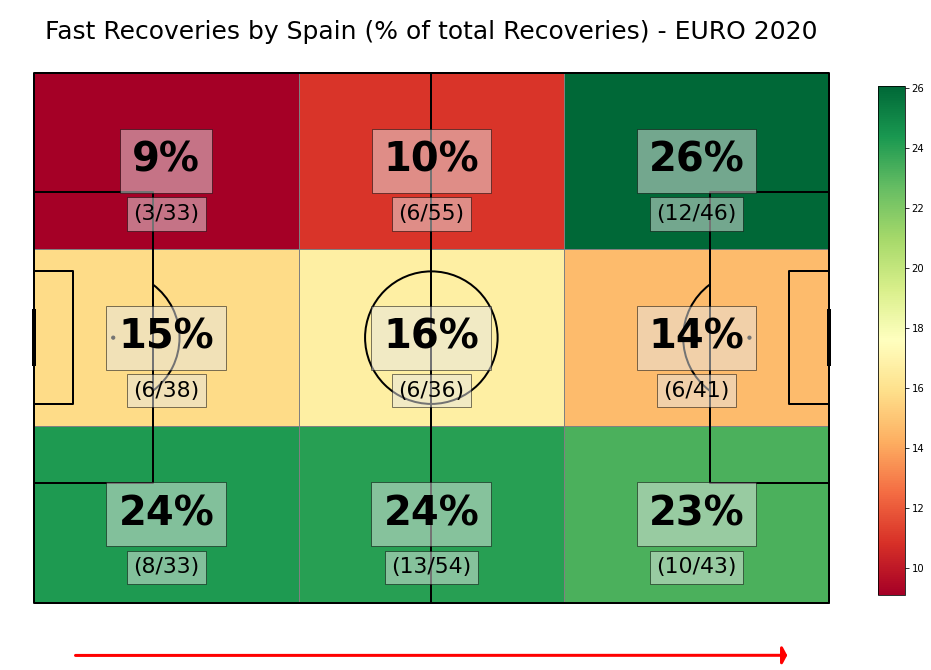

In [10]:
pitch = Pitch(line_zorder=2, line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#get the 2D histogram 
bin_statistic = pitch.bin_statistic(recoveries.x, recoveries.y, statistic='count', bins=(3, 3), normalize=False)
bin_statistic['statistic_reg'] = bin_statistic["statistic"]
bin_statistic_total = pitch.bin_statistic(full_recov.x, full_recov.y, statistic='count', bins=(3, 3), normalize=False)
#normalize by number of games
bin_statistic["statistic"] = 100*bin_statistic["statistic"]/bin_statistic_total["statistic"]
#make a heatmap
pcm  = pitch.heatmap(bin_statistic, cmap='RdYlGn', edgecolor='grey', ax=ax['pitch'])
for i in range(bin_statistic['cx'].shape[0]):
    for j in range(bin_statistic['cy'].shape[0]):
        pitch.annotate(str(int(bin_statistic['statistic'][i][j]))+'%', xy=(bin_statistic['cx'][i][j], bin_statistic['cy'][i][j]), c='black', va='center', ha='center', weight = "bold", size=40, ax=ax["pitch"], zorder = 4,bbox={'facecolor': '.9', 'edgecolor':'black', 'boxstyle':'square', 'alpha' : 0.5})
        pitch.annotate('('+str(int(bin_statistic['statistic_reg'][i][j]))+'/'+str(int(bin_statistic_total['statistic'][i][j]))+')', xy=(bin_statistic['cx'][i][j], bin_statistic['cy'][i][j]+8), c='black', va='center', ha='center', size=22, ax=ax["pitch"], zorder = 4, bbox = {'facecolor': '.9', 'edgecolor':'black', 'boxstyle':'square', 'alpha' : 0.5})
#legend to our plot
plt.annotate('', xy=(0.95, -0.005), xycoords='axes fraction', xytext=(0.05, -0.01), 
            arrowprops=dict(arrowstyle='-|>, head_width=0.75', color='red',lw=3))
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)

fig.suptitle('Fast Recoveries by ' + team + " (% of total Recoveries) - EURO 2020", fontsize = 25)
plt.show()